In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf

# Núcleos de convolución no lineales

$$\max \left(\sum_{i=1}^n b_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n y_i b_i k(x_i, x_j) y_j b_j\right)$$

sujeto a las restricciones
$$\sum_{i=1}^n b_i y_i = 0$$
$$0\le b_i\le \frac{1}{2n\gamma}$$

$k$ se denomina el núcleo (**kernel**) de la SVM
- Caso lineal $k(x_i,x_j) = x_i\cdot x_j$
- Caso general $k(x_i, x_j) = \phi(x_i)\cdot \phi(x_j)$

- Kernel Gaussiano: $k(x_i, x_j) = e^{-\gamma||x_i-x_j||^2}$
- Predicción: $k(x_i, p_j) = e^{-\gamma||x_i-p_j||^2}$

- Kernel polinomial homogéneo: $k(x_i, x_j)= (x_i\cdot x_j)^d$
- Kernel polinomial no homogéneo: $(x_i, x_j)= (x_i\cdot x_j +1)^d$
- Kernel de tangente hiperbólica: $(x_i, x_j)= tanh(a x_i\cdot x_j +k)$


In [76]:
(x_vals, y_vals) = datasets.make_circles(n_samples=500, factor=0.5, noise=0.1)

y_vals = np.array([1 if y == 1 else -1 for y in y_vals])

#creacion de datos de train y test
train_idx = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

x_vals_train = x_vals[train_idx]
x_vals_test = x_vals[test_idx]
y_vals_train = y_vals[train_idx]
y_vals_test = y_vals[test_idx]

# Convertir los datos a tensores
x_data_train = tf.convert_to_tensor(x_vals_train, dtype=tf.float32)
y_target_train = tf.convert_to_tensor(y_vals_train.reshape(-1, 1), dtype=tf.float32)

x_data_test = tf.convert_to_tensor(x_vals_test, dtype=tf.float32)
y_target_test = tf.convert_to_tensor(y_vals_test.reshape(-1, 1), dtype=tf.float32)

#Valores de los hiperparametros
batch_size = 400
learning_rate=0.002

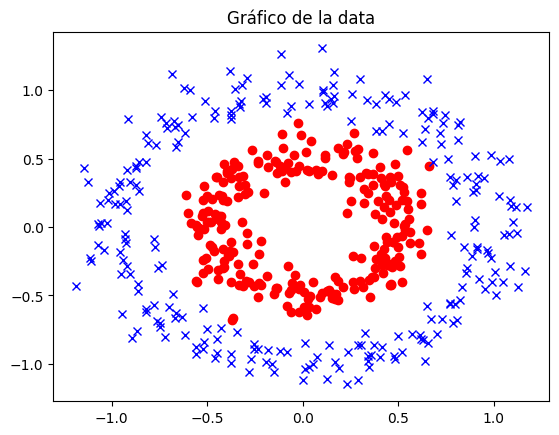

In [77]:
class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==1]

class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==-1]

#grafico de los datos completos
plt.plot(class1_x, class1_y, 'ro', label = "Clase 1")
plt.plot(class2_x, class2_y, 'bx', label = "Clase 2")
plt.title("Gráfico de la data")
plt.show()

In [78]:
# Variables del modelo
b = tf.Variable(tf.random.normal(shape=[batch_size, 1]), dtype=tf.float32)
gamma = tf.constant(-50.0)

# Kernel de la SVM
def gaussian_kernel(x, y, gamma):
    sq_dist = tf.reduce_sum(tf.square(x), axis=1, keepdims=True) + \
              tf.reduce_sum(tf.square(y), axis=1) - \
              2 * tf.matmul(x, y, transpose_b=True)
    return tf.exp(gamma * tf.abs(sq_dist))

my_kernel = gaussian_kernel(x_data_train, x_data_train, gamma)

# Definir la función de pérdida
def loss_fn(b, x_data, y_target, my_kernel):
    first_sum = tf.reduce_sum(b)
    b_vect_cross = tf.matmul(b, tf.transpose(b))
    y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
    second_sum = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vect_cross, y_target_cross)))
    return -tf.subtract(first_sum, second_sum)

# Optimización
optimizer = tf.optimizers.SGD(learning_rate=0.005)

In [79]:
# Entrenamiento
loss_vect = []
batch_acc = []

for i in range(200):
    with tf.GradientTape() as tape:
        loss = loss_fn(b, x_data_train, y_target_train, my_kernel)
    gradients = tape.gradient(loss, [b])
    optimizer.apply_gradients(zip(gradients, [b]))

    loss_vect.append(loss.numpy())

    # Precisión
    pred_sq_dist = gaussian_kernel(x_data_train, x_data_train, gamma)
    prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target_train), b), pred_sq_dist)
    prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target_train)), tf.float32))
    batch_acc.append(accuracy.numpy())

    if (i + 1) % 50 == 0:
        print(f"Paso #{i + 1}, Error = {loss.numpy()}, Precisión = {accuracy.numpy()}")

Paso #50, Error = 38.395408630371094, Precisión = 0.5292062759399414
Paso #100, Error = 3.9843711853027344, Precisión = 0.5401250123977661
Paso #150, Error = -7.011445999145508, Precisión = 0.5609562397003174
Paso #200, Error = -12.023170471191406, Precisión = 0.5759937763214111


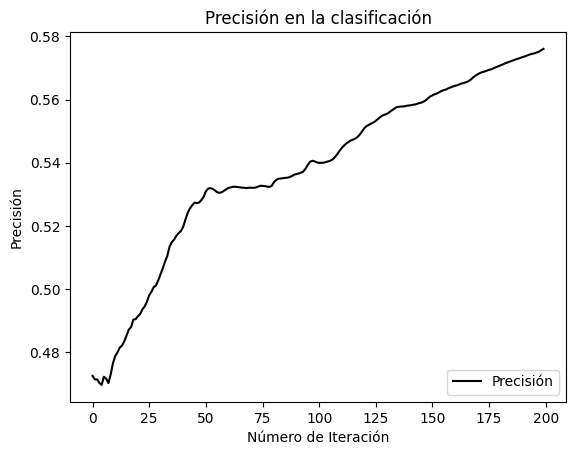

In [80]:
plt.plot(batch_acc, 'k-', label="Precisión")
plt.title("Precisión en la clasificación")
plt.xlabel("Número de Iteración")
plt.ylabel("Precisión")
plt.legend(loc="lower right")
plt.show()



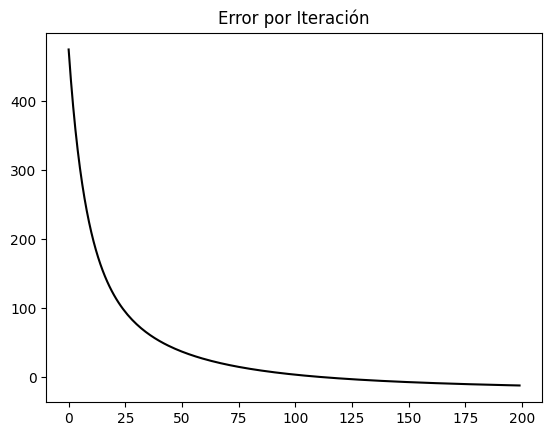

In [81]:
plt.plot(loss_vect, 'k-')
plt.title("Error por Iteración")
plt.show()